## Lect 1_Part 2 Simple LPP Problem using PyPSA

### Powerplants: Coal, gas, Renewables LPP

In [1]:
import pypsa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Create a new PyPSA network
network = pypsa.Network()
network.set_snapshots(range(1))  # Solve for a single time snapshot

# Define the buses (electricity demand)
network.add("Bus", "electricity_bus", carrier="electricity")

# Add generators (power plants) with defined emissions rate per MWh generated
network.add("Generator", "Coal", bus="electricity_bus", p_nom_extendable=False, marginal_cost=30, p_nom=60, carrier="coal")
network.add("Generator", "Gas", bus="electricity_bus", p_nom_extendable=False, marginal_cost=60, p_nom=80, carrier="gas")
network.add("Generator", "PV", bus="electricity_bus", p_nom_extendable=True, marginal_cost=0,p_nom_max=40, capital_cost=650, carrier="pv")
network.add("Generator", "Wind", bus="electricity_bus", p_nom_extendable=True, marginal_cost=0, p_nom_max=70, capital_cost=850, carrier="wind")

network.madd(
    "Carrier",
    names=["coal","gas","pv","wind"],
    color=["black","darkslategray","gold","lightseagreen"],
    co2_emissions=[0.8,0.4,0,0],
)

# Add global CO2 emissions constraint for the entire network
network.add(
    "GlobalConstraint",
    "emission_limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=60,  # Total CO2 emissions limit in tons
)

# Add load data (electricity demand)
network.add("Load", "electricity_load", bus="electricity_bus", p_set=200)

# Optimize the network to minimize the total cost
network.optimize(solver_name="highs")

# Print the results
print(network.generators_t.p)  # Power output per generator
print(f"Total Cost of Electricity Generation: {network.objective} €")
print(f"Total CO2 Emissions: {network.global_constraints.constant} tons")
# Individual emissions
emissions_ind = (network.generators_t.p/ network.generators.efficiency* network.generators.carrier.map(network.carriers.co2_emissions))
print(f"Total Emissions: {emissions_ind.sum().sum()} tons")

Index(['electricity_bus'], dtype='object', name='Bus')
Index(['electricity_bus'], dtype='object', name='Bus')
c:\Users\onkar\.conda\envs\pypsa\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.11s
INFO:linopy.solvers:Log file at C:\Users\onkar\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 18 duals
Objective: 7.01e+04
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Generator  Coal   Gas    PV  Wind
snapshot                         
0          35.0  80.0  40.0  45.0
Total Cost of Electricity Generation: 70100.0 €
Total CO2 Emissions: GlobalConstraint
emission_limit    60.0
Name: constant, dtype: float64 tons
Total Emissions: 60.0 tons


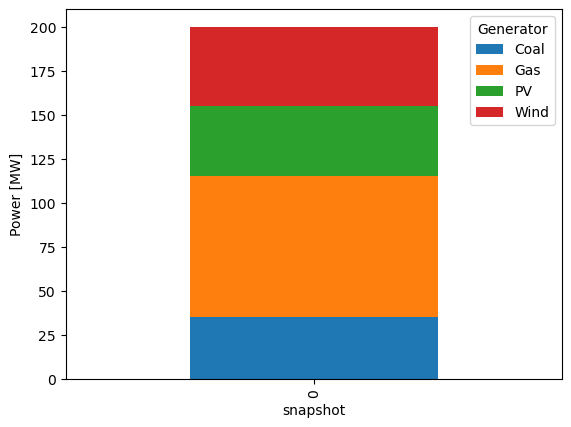

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
network.generators_t.p.plot(kind="bar", stacked=True, ax=ax)
plt.ylabel("Power [MW]")
plt.show()

<Axes: xlabel='Generator', ylabel='Total generation MW'>

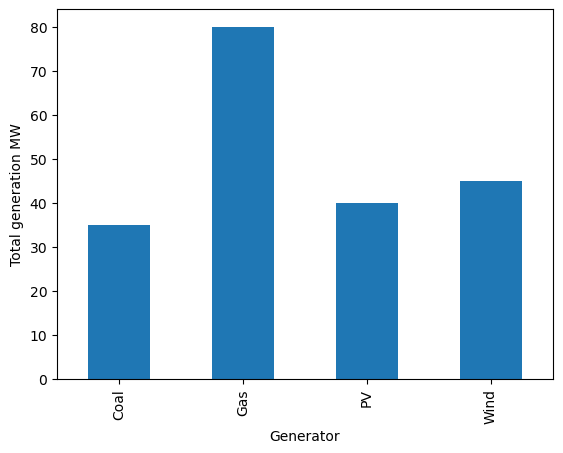

In [3]:
network.generators_t.p.sum().plot.bar(ylabel="Total generation MW")

In [4]:
network.statistics()

Optimal Capacity  Installed Capacity  Supply  Withdrawal  \
Generator coal              60.0                60.0    35.0         0.0   
          gas               80.0                80.0    80.0         0.0   
          pv                40.0                 0.0    40.0         0.0   
          wind              45.0                 0.0    45.0         0.0   
Load      -                  0.0                 0.0     0.0       200.0   

                Energy Balance Transmission  Capacity Factor  Curtailment  \
Generator coal            35.0          0.0         0.583333         25.0   
          gas             80.0          0.0         1.000000          0.0   
          pv              40.0          0.0         1.000000          0.0   
          wind            45.0          0.0         1.000000          0.0   
Load      -             -200.0          0.0              NaN          0.0   

                Capital Expenditure  Operational Expenditure   Revenue  \
Generator coal                  0.0                   1050.0   29750.0   
          gas                   0.0                   4800.0   68000.0   
          pv                26000.0                      0.0   34000.0   
          wind              38250.0                      0.0   38250.0   
Load      -                     0.0                      0.0 -170000.0   

                Market Value  
Generator coal         850.0  
          gas          850.0  
          pv           850.0  
          wind         850.0  
Load      -              NaN